
# <p style="text-align:center"> <font color='darkorange'>**CUNEF**</font>
## <p style="text-align:center"> **El Pulso Político de Twitter Análisis de las Elecciones de Madrid 2023**
### <p style="text-align:center"> **3. Modelos. Prediccion de sentiemiento**</strong><br />
    
<p style="text-align:left">Pablo Mazariegos Reviriego - <font color='orange'>pablo.mazariegos@cunef.edu </font>

En este proyecto de Trabajo Fin de Máster, realizaremos un análisis de sentimiento de los tweets hechos por los 5 candidatos políticos a la presidencia de Madrid durante el período de campaña política que abarcó desde el 12 hasta el 27 de mayo de 2023. Utilizaremos una base de datos recopilada manualmente que contiene los tweets de los candidatos. El objetivo principal de este proyecto es desarrollar modelos de aprendizaje automático que puedan clasificar los tweets según su sentimiento (positivo, negativo o neutral).

El proyecto se organizará en diferentes cuadernos, cada uno enfocado en una etapa específica del proceso:

 1. EDA y Selección/Preparación de variables.
 2. Análisis gráfico y  Word Cloud.
 3. <font color='darkgreen'> **Modelos. Predicción de sentimiento.**</font>
 4. Modelos. Predicción de Partido político.
 5. Fine tunning GPT3- Davinci. Predicción de sentimiento.
 6. Fine tunning GPT3- Davinci. Predicción de Partido político.

En este cuaderno, aplicaremos modelos de aprendizaje automático para realizar predicciones de sentimiento sobre los post. Los modelos que utilizaremos son:

- SVM
- Naive Bayes
- XGBoost Classifier
- RandomForest
- Logistic Regression

Luego de evaluar el rendimiento de estos modelos, realizaremos una optimización de hiperparámetros (hyperparameter tuning) en los dos mejores modelos seleccionados. El objetivo de esta optimización es mejorar los resultados de las predicciones de sentimiento.

En resumen, utilizaremos varios modelos de clasificación para realizar predicciones de sentimiento en los post y posteriormente mejoraremos los dos mejores modelos mediante la optimización de hiperparámetros.


  **INDICE:**
 
 - [Importación de Librerias](#0)
 - [Funciones utilizadas en este notebook](#1) 
 - [Carga de datos](#2)
 - [Vectorización y división entre train y test](#3)
 - [Modelización. Prueba de modelos (SVM, Naive Bayes, XGBoost Classifier, RandomForest, Logistic Regression)](#3.9)

  **Modelos:**
 - [SVM](#4)
 - [Naive Bayes](#5) 
 - [XGBoost Classifier](#6)
 - [RandomForest](#7)
 - [Logistic Regression](#8)
 - [Comparativo](#9)
 - [Random Forest Hiperparametros Tunning](#10)
 - [Logistic Regression Hiperparametros Tunning](#11)
 

##  <a name="0"> Importación de Librerias</a>

In [1]:
from getpass import getpass
import openai
import requests
from PIL import Image
from io import BytesIO
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
from sklearn import metrics 
import pickle
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')

##  <a name="0"> Funciones utilizadas en este notebook</a>

Esta función toma las etiquetas de prueba, las puntuaciones del modelo y el nombre del modelo como entrada, y produce un gráfico que muestra las curvas ROC para el modelo de clasificación. Las curvas ROC son útiles para evaluar el rendimiento y la precisión del modelo en diferentes umbrales de clasificación.

In [2]:
def plot_roc_curves(y_test, scores, model_name):
    # Binarizar las etiquetas
    y_test_bin = label_binarize(y_test, classes=list(set(y_test)))

    # Calcular la curva ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(set(y_test))):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la media micro de las métricas ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Graficar las curvas ROC
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='Media micro ROC (área = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue'][:len(set(y_test))]
    for i, color in enumerate(colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC de la clase {0} (área = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC para el modelo {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

Esta función toma las etiquetas de prueba, las predicciones del modelo y el nombre del modelo como entrada, y produce un informe de clasificación junto con el F2 Score para evaluar el rendimiento del modelo. El informe proporciona una descripción general del rendimiento del modelo en términos de precisión, recuperación, valor F1 y soporte para cada clase, mientras que el F2 Score da más peso a la precisión en comparación con el recuerdo

In [3]:
def print_classification_report(y_test, predictions, model_name):
    report = classification_report(y_test, predictions, labels=[2, 0, 1], 
                                   target_names=['Positivo', 'Negativo', 'Neutro'])
    f2_score = fbeta_score(y_test, predictions, beta=2, average='weighted')
    
    print(f'Model: {model_name}')
    print(report)
    print(f'F2 Score: {f2_score:.2f}')
    print('\n')

Esta función toma una lista de modelos, una lista de nombres de modelo, los datos de prueba X_test y las etiquetas de prueba y_test, y produce un informe que incluye el nombre de cada modelo y varias métricas de evaluación, como accuracy, F1-Score y F2-Score, para cada modelo.

In [4]:
def print_model_metrics(models, model_names, X_test, y_test):
    for model, model_name in zip(models, model_names):
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average='weighted')
        f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')

        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"F2-Score: {f2:.4f}")
        print()

##  <a name="2"> Carga de datos</a>

In [5]:
file_path = '../data/processed/df_sentimiento_final.csv'
df = pd.read_csv(file_path)
df = df.drop("Unnamed: 0", axis=1)
df.head()

,partido,partido_num,candidato,nick,followers,fecha,post,post_clean,sentimiento,sentimiento_num,...,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños,Num_words_POST,sentimiento_clean
0,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...","comenzamos la campana, una vez mas, junto a la...",positive,2,...,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,70,42,comenzamos campana vez mas junto agricultura c...
1,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...","madrid es la region del espiritu de ermua, la ...",negative,0,...,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70,24,madrid region espiritu ermua admite totalitari...
2,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...","majadahonda con ganas de libertad, familia, un...",positive,2,...,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70,17,majadahonda ganas libertad familia unidad aleg...
3,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,presidente: libranos del mal.,positive,2,...,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70,4,presidente libranos mal
4,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,En Madrid sólo habrá 2 tarifas de transporte p...,en madrid solo habra 2 tarifas de transporte p...,negative,0,...,0.001445,759,0.003562,3016,0.014153,1586985,0.4734,70,51,madrid solo habra 2 tarifas transporte publico...


Comprobamos y eliminamos valores nulos para evitar errores en el modelo

In [6]:
# Seleccionar la fila que contiene el valor nulo en la columna "sentimiento_clean"
fila_nula = df.loc[df['sentimiento_clean'].isnull()]

# Mostrar la fila nula
print(fila_nula)

   partido  partido_num         candidato           nick  followers  \
96     vox            1  Rocío Monasterio   @monasterioR     339700   

         fecha           post     post_clean sentimiento  sentimiento_num  \
96  2023-05-23  ¿Y tú cuándo?  ?y tu cuando?     neutral                1   

    ...  comments vs viewed  shared  shared vs viewed  likes  likes vs viewed  \
96  ...            0.002295     351          0.007389    884         0.018611   

     votos  porcentaje  escaños  Num_words_POST  sentimiento_clean  
96  245215      0.0731       11               3                NaN  

[1 rows x 29 columns]


In [7]:
df = df.drop(96)

##  <a name="3"> Vectorización y división entre train y test</a>

La función  utiliza el "TfidfVectorizer" para transformar los textos en una representación numérica utilizando TF-IDF. Los datos vectorizados se almacenan en "X", y las etiquetas de destino se almacenan en "y". Estos datos se pueden utilizar posteriormente para entrenar un modelo de clasificación en aprendizaje supervisado.

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['sentimiento_clean'])
y = df['sentimiento_num']  

Divide los datos en conjuntos de entrenamiento y prueba. Al ser un problema multiclase y para que se mantenga la proporción de todas las clases, lo hacemos con la función stratify() con un tamaño del test del 20% y entrenamiento del 80%

In [9]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

##  <a name="3.9"> Modelización. Prueba de modelos (SVM, Naive Bayes, XGBoost Classifier, RandomForest, Logistic Regression)</a>

A continuación, vamos a probar varios modelos de clasificación para evaluar su rendimiento en el problema dado. Los modelos que vamos a probar son: SVM, Naive Bayes, XGBoost Classifier, RandomForest y Logistic Regression. En esta primera etapa, utilizaremos los modelos con sus configuraciones predeterminadas, es decir, sin ajustar sus hiperparámetros.

Luego, procederemos a entrenar y evaluar cada uno de los modelos mencionados utilizando los datos de entrenamiento y prueba. Calcularemos métricas de evaluación como accuracy, precisión, recall y F1-Score para cada modelo.

Una vez que hayamos evaluado los modelos sin hiperparámetros, seleccionaremos los mejores modelos en función de su rendimiento y procederemos a ajustar sus hiperparámetros. Esto nos permitirá mejorar aún más su desempeño y obtener el mejor modelo posible para nuestro problema.

**MÉTRICAS:**

Para poder evaluar nuestro modelo nos fijaremos principalmente en los reslutados de las métricas de F1-score, Accuracy y F2-score.

•	F2-score: El F2-score es una métrica que combina la precisión y el recall para calcular una puntuación única. Se utiliza comúnmente en problemas de clasificación desbalanceados, donde hay una diferencia significativa en la distribución de las clases. El F2-score da más peso al recall, lo que significa que se centra en reducir los falsos negativos. En el contexto de generación de texto, puede ser útil si el objetivo es minimizar los casos en los que se omita información importante o se generen textos incompletos.

 
•	Accuracy: El accuracy es una métrica que mide la proporción de predicciones correctas en relación con el total de predicciones. Es una métrica simple y fácil de interpretar. Sin embargo, en el contexto de generación de texto, donde la salida es un texto largo y diverso, el accuracy puede ser limitado ya que no considera la calidad del texto generado ni captura la variabilidad en las respuestas posibles. No obstante, puede ser útil para evaluar modelos que generan respuestas de opción múltiple o clasifican textos generados en categorías predefinidas.



•	F1-score: El F1-score es otra métrica que combina la precisión y el recall, pero da el mismo peso a ambos. Es adecuado cuando se desea un equilibrio entre precisión y recall. En el contexto de generación de texto, puede ser útil para evaluar la calidad general de los textos generados, teniendo en cuenta tanto la precisión (exactitud del contenido) como el recall (cobertura de la información relevante).


##  <a name="4"> SVM</a>

In [10]:
# Entrenar un modelo SVM
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, svm_classifier)
svm_predictions = svm_classifier.predict(X_test)

**Imprimimos las métricas:**

In [11]:
print_classification_report(y_test, svm_predictions, 'SVM')

Model: SVM
              precision    recall  f1-score   support

    Positivo       1.00      0.07      0.12        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.62      0.94      0.75        77

   micro avg       0.62      0.79      0.70        92
   macro avg       0.54      0.33      0.29        92
weighted avg       0.68      0.79      0.64        92

F2 Score: 0.64




**Matriz de confusión (Negativo 0, Neutral 1, Positivo 2):**

[[72  0  5]
 [12  1  2]
 [32  0 30]]


<Axes: >

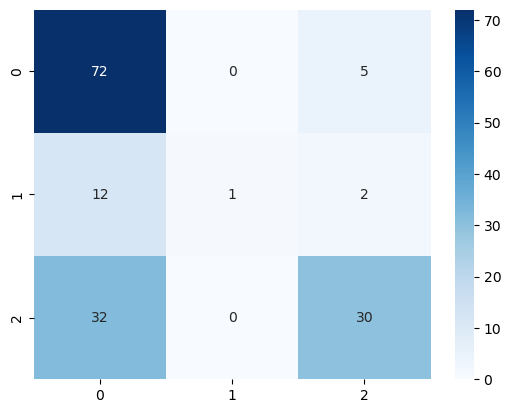

In [12]:
print(confusion_matrix(y_test,svm_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, svm_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

Para la clase Negativo (0):

Verdaderos Negativos (TN): Hay 72 ejemplos clasificados correctamente como Negativo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Negativo.
Falsos Negativos (FN): Hay 5 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Negativo.

Para la clase Neutral (1):

Verdaderos Negativos (TN): Hay 1 ejemplo clasificado correctamente como Neutral.
Falsos Positivos (FP): Hay 12 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Negativo.
Falsos Negativos (FN): Hay 2 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Neutral.

Para la clase Positivo (2):

Verdaderos Negativos (TN): No hay ejemplos clasificados incorrectamente como Positivo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Positivo.
Falsos Negativos (FN): Hay 32 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Negativo.
Verdaderos Positivos (TP): Hay 30 ejemplos clasificados correctamente como Positivo.

**Curva Roc Multiclase (Negativo 0, Neutral 1, Positivo 2):**

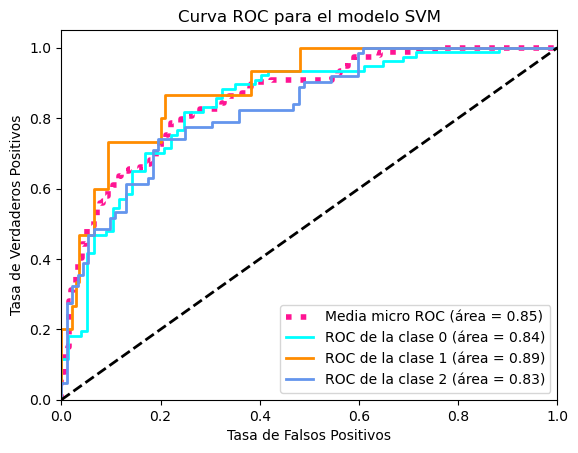

In [13]:
scores = svm_classifier.decision_function(X_test)
plot_roc_curves(y_test, scores, 'SVM')

In [14]:
# Save the model.
pickle.dump(model, open('../models/svc_model_tweets_sent.pkl', 'wb'))

##  <a name="5"> Naive Bayes</a>

In [15]:
# Entrenar un modelo Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, nb_classifier)
nb_predictions = nb_classifier.predict(X_test)

**Imprimimos las métricas:**

In [16]:
print_classification_report(y_test, nb_predictions, 'Naive Bayes')

Model: Naive Bayes
              precision    recall  f1-score   support

    Positivo       0.00      0.00      0.00        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.67      0.79      0.73        77

   micro avg       0.67      0.66      0.67        92
   macro avg       0.22      0.26      0.24        92
weighted avg       0.56      0.66      0.61        92

F2 Score: 0.67




**Matriz de confusión (Negativo 0, Neutral 1, Positivo 2):**

[[61  0 16]
 [13  0  2]
 [17  0 45]]


<Axes: >

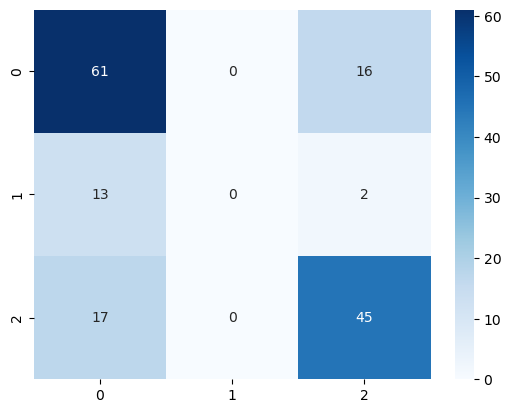

In [17]:
print(confusion_matrix(y_test,nb_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, nb_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

Para la clase Negativo (0):

Verdaderos Negativos (TN): Hay 61 ejemplos clasificados correctamente como Negativo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Negativo.
Falsos Negativos (FN): Hay 16 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Negativo.
    
Para la clase Neutral (1):

Verdaderos Negativos (TN): No hay ejemplos clasificados incorrectamente como Neutral.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Neutral.
Falsos Negativos (FN): Hay 13 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Neutral.
    
Para la clase Positivo (2):

Verdaderos Negativos (TN): No hay ejemplos clasificados incorrectamente como Positivo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Positivo.
Falsos Negativos (FN): Hay 17 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Negativo.
Verdaderos Positivos (TP): Hay 45 ejemplos clasificados correctamente como Positivo.

**Curva Roc Multiclase (Negativo 0, Neutral 1, Positivo 2):**

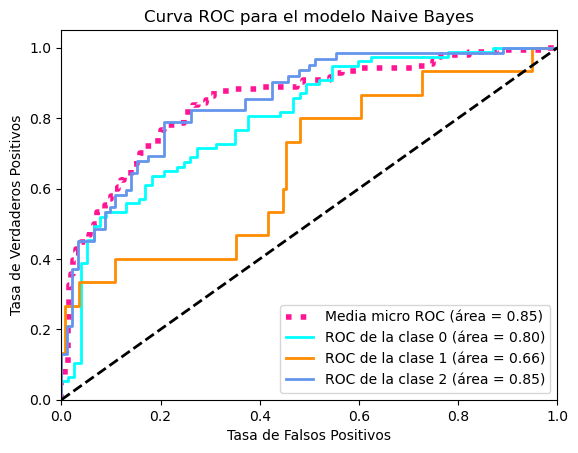

In [18]:
scores = nb_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Naive Bayes')

In [19]:
# Save the model.
pickle.dump(model, open('../models/nb_model_tweets_sent.pkl', 'wb'))

##  <a name="6"> XGBoost Classifier</a>

In [20]:
# Entrenar un modelo XGBClassifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, xgb_classifier)
xgb_predictions = xgb_classifier.predict(X_test)

**Imprimimos las métricas:**

In [21]:
print_classification_report(y_test, xgb_predictions, 'XGBoost')

Model: XGBoost
              precision    recall  f1-score   support

    Positivo       0.40      0.40      0.40        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.69      0.79      0.73        77

   micro avg       0.64      0.73      0.68        92
   macro avg       0.36      0.40      0.38        92
weighted avg       0.64      0.73      0.68        92

F2 Score: 0.67




**Matriz de confusión:**

[[61  4 12]
 [ 7  6  2]
 [21  5 36]]


<Axes: >

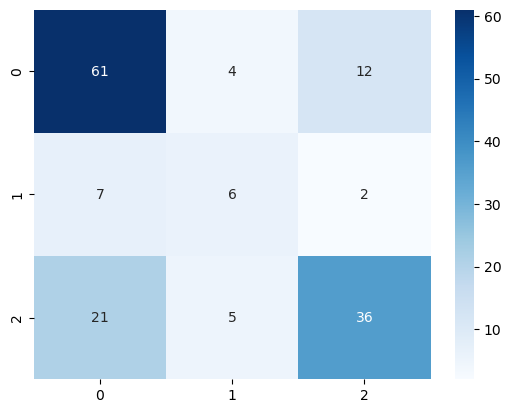

In [22]:
print(confusion_matrix(y_test,xgb_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, xgb_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

Para la clase Negativo (0):

Verdaderos Negativos (TN): Hay 61 ejemplos clasificados correctamente como Negativo.
Falsos Positivos (FP): Hay 4 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Neutral.
Falsos Negativos (FN): Hay 12 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Negativo.
    
Para la clase Neutral (1):

Verdaderos Negativos (TN): Hay 6 ejemplos clasificados correctamente como Neutral.
Falsos Positivos (FP): Hay 7 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Negativo.
Falsos Negativos (FN): Hay 2 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): Hay 6 ejemplos clasificados correctamente como Neutral.
    
Para la clase Positivo (2):

Verdaderos Negativos (TN): Hay 36 ejemplos clasificados correctamente como Positivo.
Falsos Positivos (FP): Hay 5 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Neutral.
Falsos Negativos (FN): Hay 21 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Negativo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Positivo.

In [23]:
# Save the model.
pickle.dump(model, open('../models/xgb_model_tweets_sent.pkl', 'wb'))

**Curva Roc Multiclase (Negativo 0, Neutral 1, Positivo 2):**

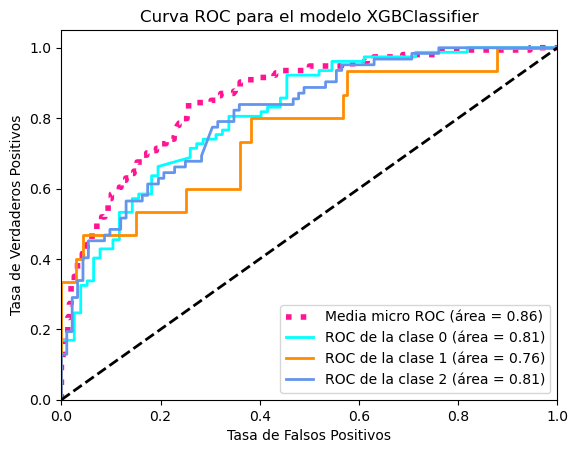

In [24]:
scores = xgb_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'XGBClassifier')

##  <a name="7"> Random Forest</a>

In [25]:
# Entrenar un modelo RandomForest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, rf_classifier)
rf_predictions = rf_classifier.predict(X_test)

**Imprimimos las métricas:**

In [26]:
print_classification_report(y_test, rf_predictions, 'Random Forest')

Model: Random Forest
              precision    recall  f1-score   support

    Positivo       0.67      0.27      0.38        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.67      0.87      0.76        77

   micro avg       0.67      0.77      0.72        92
   macro avg       0.45      0.38      0.38        92
weighted avg       0.67      0.77      0.70        92

F2 Score: 0.69




**Matriz de confusión (Negativo 0, Neutral 1, Positivo 2):**

[[67  0 10]
 [10  4  1]
 [23  2 37]]


<Axes: >

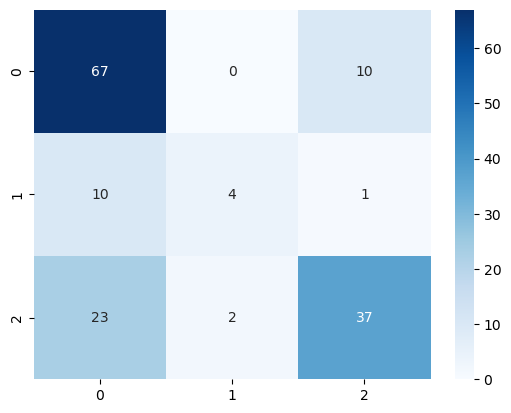

In [27]:
print(confusion_matrix(y_test,rf_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, rf_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

Para la clase Negativo (0):

Verdaderos Negativos (TN): Hay 61 ejemplos clasificados correctamente como Negativo.
Falsos Positivos (FP): Hay 4 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Neutral.
Falsos Negativos (FN): Hay 12 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Negativo.

Para la clase Neutral (1):

Verdaderos Negativos (TN): Hay 6 ejemplos clasificados correctamente como Neutral.
Falsos Positivos (FP): Hay 7 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Negativo.
Falsos Negativos (FN): Hay 2 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): Hay 6 ejemplos clasificados correctamente como Neutral.

Para la clase Positivo (2):

Verdaderos Negativos (TN): Hay 36 ejemplos clasificados correctamente como Positivo.
Falsos Positivos (FP): Hay 5 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Neutral.
Falsos Negativos (FN): Hay 21 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Negativo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Positivo.

In [28]:
# Save the model.
pickle.dump(model, open('../models/rf_model_tweets_sent.pkl', 'wb'))

**Curva Roc Multiclase (Negativo 0, Neutral 1, Positivo 2):**

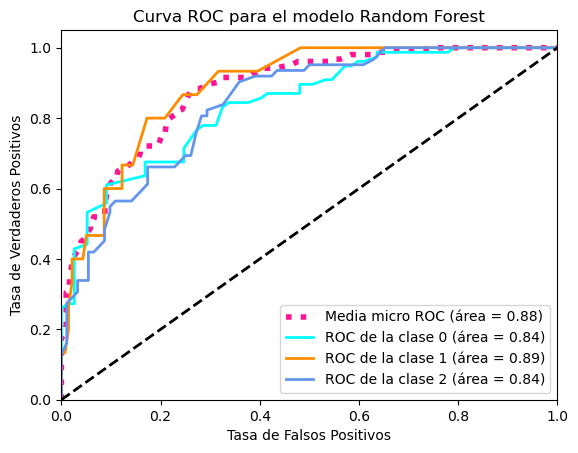

In [29]:
scores = rf_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Random Forest')

##  <a name="8"> Logistic Regression</a>

In [30]:
# Entrenar un modelo de Regresión Logística
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, lr_classifier)
lr_predictions = lr_classifier.predict(X_test)

**Imprimimos las métricas:**

In [31]:
print_classification_report(y_test, lr_predictions, 'Logistic Regresion')

Model: Logistic Regresion
              precision    recall  f1-score   support

    Positivo       0.00      0.00      0.00        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.65      0.86      0.74        77

   micro avg       0.65      0.72      0.68        92
   macro avg       0.22      0.29      0.25        92
weighted avg       0.55      0.72      0.62        92

F2 Score: 0.66




**Matriz de confusión (Negativo 0, Neutral 1, Positivo 2):**

[[66  0 11]
 [12  0  3]
 [23  0 39]]


<Axes: >

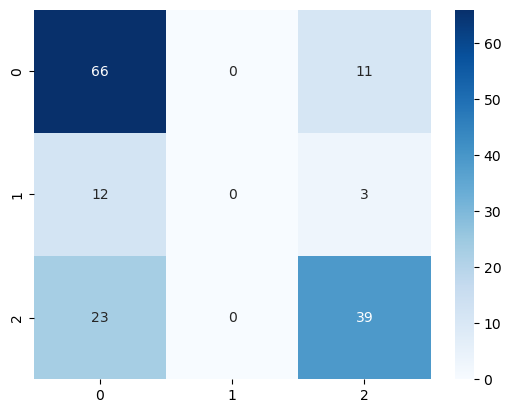

In [32]:
print(confusion_matrix(y_test,lr_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, lr_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

Para la clase Negativo (0):

Verdaderos Negativos (TN): Hay 66 ejemplos clasificados correctamente como Negativo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Negativo.
Falsos Negativos (FN): Hay 11 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Negativo.

Para la clase Neutral (1):

Verdaderos Negativos (TN): No hay ejemplos clasificados incorrectamente como Neutral.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Neutral.
Falsos Negativos (FN): Hay 12 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Neutral.

Para la clase Positivo (2):

Verdaderos Negativos (TN): Hay 39 ejemplos clasificados correctamente como Positivo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Positivo.
Falsos Negativos (FN): Hay 23 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Negativo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Positivo.

In [33]:
# Save the model.

pickle.dump(model, open('../models/lr_model_tweets_sent.pkl', 'wb'))

**Curva Roc Multiclase (Negativo 0, Neutral 1, Positivo 2):**

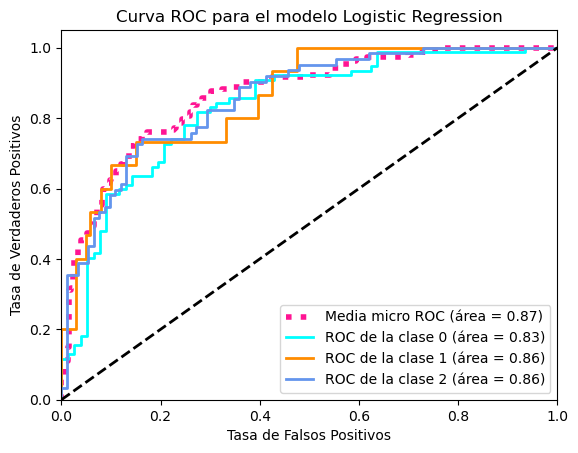

In [34]:
scores = lr_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Logistic Regression')

##  <a name="9"> Comparativo</a>

In [35]:
# Uso de la función con tus modelos y datos de prueba
models = [svm_classifier, nb_classifier, xgb_classifier, rf_classifier, lr_classifier]
model_names = ['SVM', 'Naive Bayes', 'XGBClassifier', 'RandomForest', 'Logistic Regression']
print_model_metrics(models, model_names, X_test, y_test)

Model: SVM
Accuracy: 0.6688
F1-Score: 0.6292
F2-Score: 0.6444

Model: Naive Bayes
Accuracy: 0.6883
F1-Score: 0.6530
F2-Score: 0.6735

Model: XGBClassifier
Accuracy: 0.6688
F1-Score: 0.6652
F2-Score: 0.6663

Model: RandomForest
Accuracy: 0.7013
F1-Score: 0.6865
F2-Score: 0.6917

Model: Logistic Regression
Accuracy: 0.6818
F1-Score: 0.6439
F2-Score: 0.6642



Tras comparar las metricas, pasamos a realizar un tunning de los parametros de los modelos:
 - Random Forest
 - Naive Bayes

##  <a name="10"> Random Forest</a>

La función GridSearchCV se utiliza para realizar una búsqueda exhaustiva de los mejores hiperparámetros para un modelo utilizando validación cruzada. Los parámetros que has definido para ajustar son:

n_estimators: Número de árboles en el bosque aleatorio. Se probarán los valores [100, 200, 300].

max_depth: Profundidad máxima de cada árbol en el bosque aleatorio. Se probarán los valores [None, 5, 10]. El valor "None" significa que no hay límite en la profundidad.

min_samples_split: Número mínimo de muestras requeridas para dividir un nodo interno. Se probarán los valores [2, 5, 10].

min_samples_leaf: Número mínimo de muestras requeridas en cada hoja del árbol. Se probarán los valores [1, 2, 4].

max_features: Número máximo de características a considerar al buscar la mejor división. Se probarán los valores ['auto', 'sqrt', 'log2']. 
El valor "auto" utiliza todas las características, mientras que "sqrt" y "log2" utilizan la raíz cuadrada y el logaritmo base 2 del número total de características, respectivamente.

La función GridSearchCV explorará todas las combinaciones posibles de estos hiperparámetros y seleccionará los mejores valores que maximicen la métrica de evaluación especificada (por ejemplo, precisión, F1-Score, etc.) utilizando validación cruzada.

In [36]:
# Define los parámetros que quieres ajustar
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Crea una nueva instancia del modelo
rf_classifier = RandomForestClassifier()

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid=params, cv=5)

# Ajusta los datos
grid_search.fit(X_train, y_train)

# Imprime los mejores parámetros
print("Best Parameters: ", grid_search.best_params_)

# Predice con los mejores parámetros
rf_predictions = grid_search.predict(X_test)

Best Parameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


**Imprimimos las métricas:**

In [37]:
print_classification_report(y_test, rf_predictions, 'Random Forest')

Model: Random Forest
              precision    recall  f1-score   support

    Positivo       1.00      0.20      0.33        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.74      0.83      0.78        77

   micro avg       0.74      0.73      0.74        92
   macro avg       0.58      0.34      0.37        92
weighted avg       0.78      0.73      0.71        92

F2 Score: 0.74




**Curva Roc Multiclase (Negativo 0, Neutral 1, Positivo 2):**

Model: Random Forest
Accuracy: 0.7468
F1-Score: 0.7295
F2-Score: 0.7379



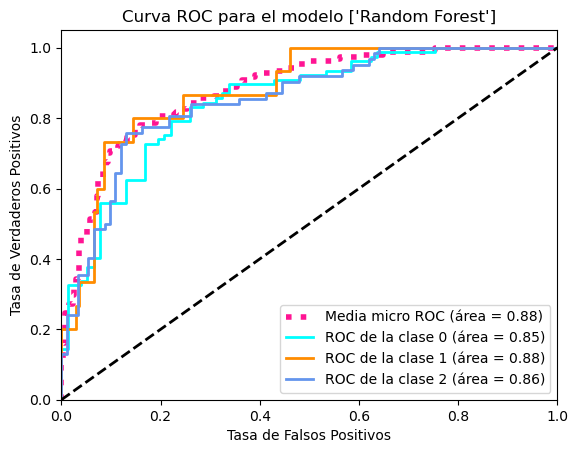

In [38]:
# Uso de la función con tus modelos y datos de prueba
models = [grid_search.best_estimator_]
model_names = ['Random Forest']
print_model_metrics(models, model_names, X_test, y_test)

# Para usar la función plot_roc_curves, necesitas las puntuaciones de confianza de tu modelo
y_scores = grid_search.predict_proba(X_test)

# Ahora puedes llamar a tu función
y_scores = grid_search.predict_proba(X_test)
# Ahora puedes llamar a tu función
plot_roc_curves(y_test, y_scores, model_names)

In [39]:
# Save the model.
pickle.dump(model, open('../models/xgb_model_tweets_sent_final.pkl', 'wb'))

**Matriz de confusión (Negativo 0, Neutral 1, Positivo 2):**

[[64  0 13]
 [ 9  3  3]
 [14  0 48]]


<Axes: >

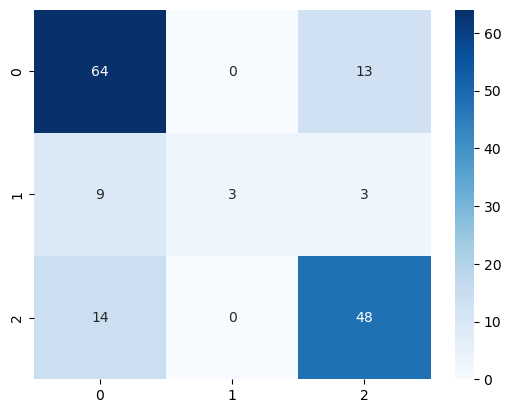

In [40]:
print(confusion_matrix(y_test,rf_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, rf_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

Para la clase Negativo (0):

Verdaderos Negativos (TN): Hay 64 ejemplos clasificados correctamente como Negativo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Negativo.
Falsos Negativos (FN): Hay 13 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Negativo.

Para la clase Neutral (1):

Verdaderos Negativos (TN): Hay 3 ejemplos clasificados correctamente como Neutral.
Falsos Positivos (FP): Hay 9 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Negativo.
Falsos Negativos (FN): Hay 3 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): Hay 3 ejemplos clasificados correctamente como Neutral.

Para la clase Positivo (2):

Verdaderos Negativos (TN): Hay 48 ejemplos clasificados correctamente como Positivo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Positivo.
Falsos Negativos (FN): Hay 14 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Negativo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Positivo.

##  <a name="11"> Naive Bayes</a>

La función GridSearchCV se utiliza para realizar una búsqueda exhaustiva de los mejores hiperparámetros para un modelo utilizando validación cruzada. Los parámetros que has definido para ajustar son los siguientes:

alpha: Parámetro de suavizado Laplaciano. Se probarán los valores [0.1, 0.5, 1.0].

fit_prior: Indica si se deben ajustar las probabilidades a priori de clase. Se probarán los valores [True, False].

class_prior: Probabilidades a priori de clase. Se probarán los valores [None, [0.2, 0.3, 0.2, 0.1, 0.2]].

La función GridSearchCV explorará todas las combinaciones posibles de estos hiperparámetros y seleccionará los mejores valores que maximicen la métrica de evaluación especificada utilizando validación cruzada.

In [41]:
# Define los parámetros que quieres ajustar
params = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False],
    'class_prior': [None, [0.2, 0.3, 0.2, 0.1, 0.2]],
}

# Crea una nueva instancia del modelo
nb_classifier = MultinomialNB()

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(nb_classifier, param_grid=params, cv=5)
S
# Ajusta los datos
grid_search.fit(X_train, y_train)

# Imprime los mejores parámetros
print("Best Parameters: ", grid_search.best_params_)

# Predice con los mejores parámetros
nb_predictions = grid_search.predict(X_test)

Best Parameters:  {'alpha': 0.5, 'class_prior': None, 'fit_prior': True}


**Imprimimos las métricas:**

In [42]:
print_classification_report(y_test, nb_predictions, 'Naive Bayes')

Model: Naive Bayes
              precision    recall  f1-score   support

    Positivo       1.00      0.07      0.12        15
    Negativo       0.00      0.00      0.00         0
      Neutro       0.70      0.71      0.71        77

   micro avg       0.70      0.61      0.65        92
   macro avg       0.57      0.26      0.28        92
weighted avg       0.75      0.61      0.61        92

F2 Score: 0.67




**Curva Roc Multiclase (Negativo 0, Neutral 1, Positivo 2):**

Model: Naive Bayes
Accuracy: 0.6818
F1-Score: 0.6548
F2-Score: 0.6696



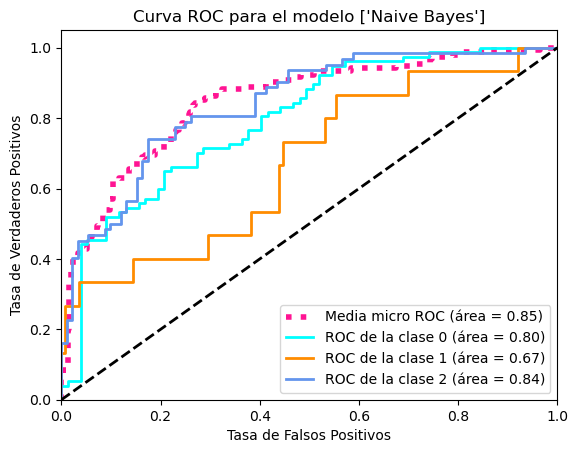

In [43]:
# Uso de la función con tus modelos y datos de prueba
models = [grid_search.best_estimator_]
model_names = ['Naive Bayes']
print_model_metrics(models, model_names, X_test, y_test)

# Para usar la función plot_roc_curves, necesitas las puntuaciones de confianza de tu modelo
y_scores_nb = grid_search.predict_proba(X_test)

# Ahora puedes llamar a tu función
plot_roc_curves(y_test, y_scores_nb, model_names)

In [44]:
# Guardar el modelo
pickle.dump(model, open('../models/lr_model_tweets_sent_final.pkl', 'wb'))

**Matriz de confusión (Negativo 0, Neutral 1, Positivo 2):**

[[66  0 11]
 [12  0  3]
 [23  0 39]]


<Axes: >

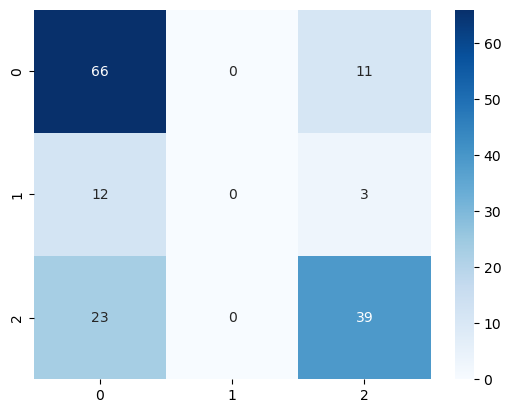

In [45]:
# Matriz de confusión
conf_mat = confusion_matrix(y_test, lr_predictions)
print(conf_mat)

# Plot de la matriz de confusión
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

Para la clase Negativo (0):

Verdaderos Negativos (TN): Hay 66 ejemplos clasificados correctamente como Negativo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Negativo.
Falsos Negativos (FN): Hay 11 ejemplos que deberían haber sido clasificados como Negativo pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Negativo.

Para la clase Neutral (1):

Verdaderos Negativos (TN): No hay ejemplos clasificados incorrectamente como Neutral.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Neutral.
Falsos Negativos (FN): Hay 12 ejemplos que deberían haber sido clasificados como Neutral pero se clasificaron incorrectamente como Positivo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Neutral.

Para la clase Positivo (2):

Verdaderos Negativos (TN): Hay 39 ejemplos clasificados correctamente como Positivo.
Falsos Positivos (FP): No hay ejemplos clasificados incorrectamente como Positivo.
Falsos Negativos (FN): Hay 23 ejemplos que deberían haber sido clasificados como Positivo pero se clasificaron incorrectamente como Negativo.
Verdaderos Positivos (TP): No hay ejemplos clasificados incorrectamente como Positivo.